# Project For Applied Artificial Intellence Class 501
Strategic Planning of Cycling Infrastructure Through
Built Environment Analysis and Network Optimization

In [ ]:
! pip install osmnx contextily

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import geopandas as gpd
import networkx as nx
import osmnx as ox

from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler


def plot_clusters(gdf, cluster_col, ax, title):

    # --- Create the Map Visualization ---
    # Create two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # --- Plot 1: DBSCAN Clusters ---
    gdf.plot(
        column='dbscan_cluster', # Color roads by this column
        categorical=True,       # Treat cluster labels as distinct categories
        legend=True,            # Show the legend
        linewidth=2,            # Make lines thicker
        ax=ax1,                 # Draw on the first subplot
        cmap='viridis'          # Colormap
    )
    ax1.set_title('DBSCAN Clusters on Map')
    ax1.set_axis_off()
    # Add a basemap for context (requires re-projecting on the fly)
    ctx.add_basemap(ax1, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    # --- Plot 2: KMeans Clusters ---
    gdf.plot(
        column='kmeans_cluster',
        categorical=True,
        legend=True,
        linewidth=2,
        ax=ax2,
        cmap='viridis'
    )
    ax2.set_title('KMeans Clusters on Map')
    ax2.set_axis_off()
    # Add a basemap for context
    ctx.add_basemap(ax2, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    plt.tight_layout()
    plt.show()

ModuleNotFoundError: No module named 'contextily'

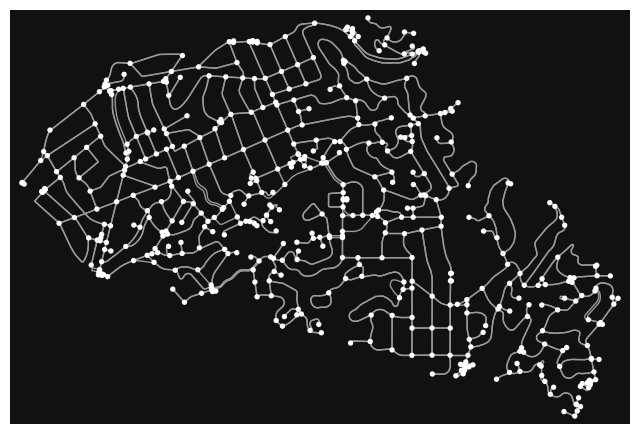

In [2]:
# Increase max query area size (e.g., to 100km * 100km)
# The default is 50km * 50km = 2,500,000,000
#new_max_size = 100000 * 100000  # units are meters
#ox.config(max_query_area_size=new_max_size)

# download/model a street network for some city then visualize it
G = ox.graph.graph_from_place("Piedmont, California, USA", network_type="bike")
fig, ax = ox.plot.plot_graph(G)

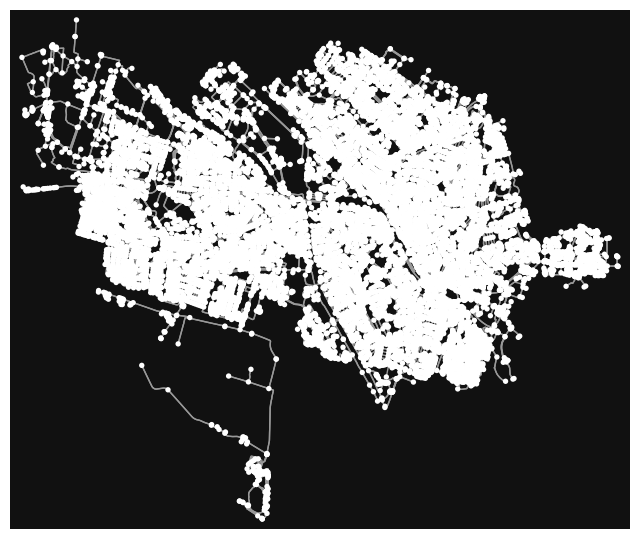

In [ ]:
G = ox.graph.graph_from_place("Utrecht, Netherlands", network_type="bike")
fig, ax = ox.plot.plot_graph(G)

In [ ]:
#-------------------------------EDA-------------------------------------

G = ox.graph_from_place("Amsterdam, Netherlands", network_type="bike") #Just exploring
nodes, edges = ox.graph_to_gdfs(G)

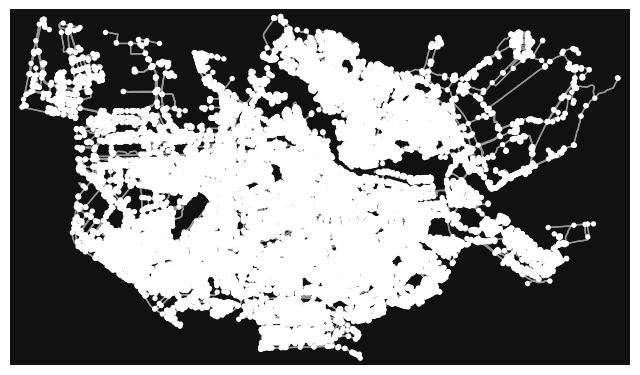

In [ ]:
fig, ax = ox.plot.plot_graph(G)

In [ ]:
nodes, edges = ox.graph_to_gdfs(G)
nodes.head()

,y,x,street_count,highway,railway,ref,geometry
osmid,,,,,,,
6316199,52.370173,4.888396,4,NaN,NaN,NaN,POINT (4.8884 52.37017)
25596477,52.367000,4.906097,3,NaN,NaN,NaN,POINT (4.9061 52.367)
25645990,52.366326,4.926110,3,NaN,NaN,NaN,POINT (4.92611 52.36633)
25658577,52.365959,4.930890,3,NaN,NaN,NaN,POINT (4.93089 52.36596)
25658578,52.365569,4.930769,3,NaN,NaN,NaN,POINT (4.93077 52.36557)


In [ ]:
edges.head()

osmid      highway  \
u        v         key                                               
6316199  26605707  0                          4745774     cycleway   
         46379627  0    [38297120, 7372610, 38297119]  residential   
         46389218  0                          7372614  residential   
25596477 252100622 0                         23289374   pedestrian   
         687718509 0                         23289375  residential   

                                                              name  oneway  \
u        v         key                                                       
6316199  26605707  0                                     Raamsteeg   False   
         46379627  0    [Joes Kloppenburgbrug, Oude Spiegelstraat]   False   
         46389218  0                                        Singel    True   
25596477 252100622 0                      Jonas Daniël Meijerplein   False   
         687718509 0                            Nieuwe Herengracht   False   

                       width reversed      length  \
u        v         key                              
6316199  26605707  0    1.80     True   50.190831   
         46379627  0     NaN    False   42.496919   
         46389218  0     NaN    False  225.577040   
25596477 252100622 0     NaN     True   89.761236   
         687718509 0     NaN    False   61.291976   

                                                                 geometry  \
u        v         key                                                      
6316199  26605707  0    LINESTRING (4.8884 52.37017, 4.88847 52.37017,...   
         46379627  0    LINESTRING (4.8884 52.37017, 4.88827 52.37018,...   
         46389218  0    LINESTRING (4.8884 52.37017, 4.88873 52.37195,...   
25596477 252100622 0    LINESTRING (4.9061 52.367, 4.90576 52.36687, 4...   
         687718509 0    LINESTRING (4.9061 52.367, 4.90612 52.36702, 4...   

                       maxspeed bridge service lanes  ref access tunnel  \
u        v         key                                                    
6316199  26605707  0        NaN    NaN     NaN   NaN  NaN    NaN    NaN   
         46379627  0         30    yes     NaN   NaN  NaN    NaN    NaN   
         46389218  0         30    NaN     NaN   NaN  NaN    NaN    NaN   
25596477 252100622 0        NaN    NaN     NaN   NaN  NaN    NaN    NaN   
         687718509 0         30    NaN     NaN   NaN  NaN    NaN    NaN   

                       junction est_width area  
u        v         key                          
6316199  26605707  0        NaN       NaN  NaN  
         46379627  0        NaN       NaN  NaN  
         46389218  0        NaN       NaN  NaN  
25596477 252100622 0        NaN       NaN  NaN  
         687718509 0        NaN       NaN  NaN

In [ ]:
null_length=edges['length'].isna().sum()
max_length=edges['length'].max()

print(null_length)
print(max_length)

0
2540.064723416302


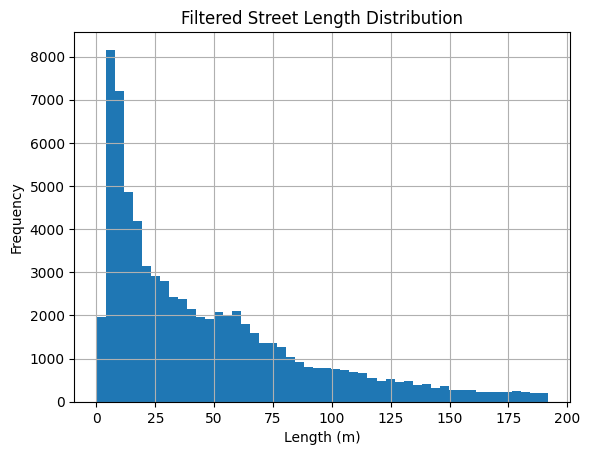

In [ ]:
threshold = edges['length'].quantile(0.95) #Using 95% to avoid outliers that distort the scale of the plot
filtered_edges = edges[edges['length'] <= threshold]
filtered_edges['length'].hist(bins=50)
plt.title("Filtered Street Length Distribution")
plt.xlabel("Length (m)")
plt.ylabel("Frequency")
plt.show()

The histogram shows a strongly right-skewed distribution of street segment lengths, with most values concentrated between 0 and 25 meters. This indicates that the cycling network is made up of very short and highly segmented paths, which may reflect dense infrastructure, frequent intersections, or mapping granularity. By removing the top 5% of outliers, the analysis focuses on the core structure without distortion from unusually long segments.

Text(0.5, 0, 'Count')

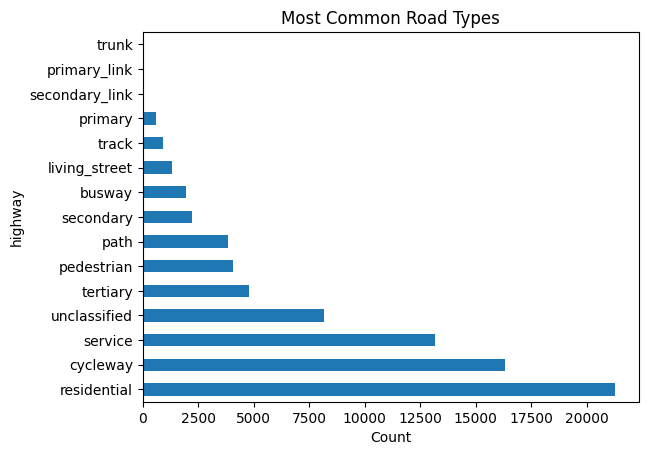

In [ ]:
edges['highway'].explode().value_counts().head(15).plot(kind='barh')
plt.title("Most Common Road Types")
plt.xlabel("Count")

In [3]:
# Piedmunt, California.
nodes, edges = ox.graph_to_gdfs(G)
nodes.head()

,y,x,street_count,highway,junction,geometry
osmid,,,,,,
53017091,37.826250,-122.247604,3,NaN,NaN,POINT (-122.2476 37.82625)
53018397,37.824220,-122.247198,3,stop,NaN,POINT (-122.2472 37.82422)
53018399,37.824900,-122.246113,3,NaN,NaN,POINT (-122.24611 37.8249)
53018402,37.825406,-122.245338,3,NaN,NaN,POINT (-122.24534 37.82541)
53018404,37.825948,-122.244467,3,NaN,NaN,POINT (-122.24447 37.82595)


In [4]:
edges.head()

osmid      highway          name  oneway reversed  \
u        v        key                                                          
53017091 53064327 0      6345781  residential   Rose Avenue   False    False   
         53075599 0      6345781  residential   Rose Avenue   False     True   
53018397 53018399 0      6327298  residential   Lake Avenue   False    False   
         53018411 0    196739937     tertiary  Linda Avenue   False    False   
         53097980 0    196739937     tertiary  Linda Avenue   False     True   

                           length  \
u        v        key               
53017091 53064327 0    230.124412   
         53075599 0    122.234915   
53018397 53018399 0    121.647438   
         53018411 0     37.593760   
         53097980 0    100.205124   

                                                                geometry  \
u        v        key                                                      
53017091 53064327 0    LINESTRING (-122.2476 37.82625, -122.2475 37.8...   
         53075599 0    LINESTRING (-122.2476 37.82625, -122.24771 37....   
53018397 53018399 0    LINESTRING (-122.2472 37.82422, -122.24712 37....   
         53018411 0    LINESTRING (-122.2472 37.82422, -122.24713 37....   
         53097980 0    LINESTRING (-122.2472 37.82422, -122.24772 37....   

                      lanes maxspeed bridge service junction access  
u        v        key                                                
53017091 53064327 0     NaN      NaN    NaN     NaN      NaN    NaN  
         53075599 0     NaN      NaN    NaN     NaN      NaN    NaN  
53018397 53018399 0     NaN      NaN    NaN     NaN      NaN    NaN  
         53018411 0     NaN      NaN    NaN     NaN      NaN    NaN  
         53097980 0     NaN      NaN    NaN     NaN      NaN    NaN

In [7]:
nodes.shape, edges.shape

((499, 6), (1248, 13))

In [8]:
type(edges)

geopandas.geodataframe.GeoDataFrame

In [ ]:
# Your data starts in a standard geographic CRS
gdf = gpd.GeoDataFrame(edges, crs="EPSG:4326")
# Re-project the data to the correct projected CRS for Piedmont, CA
#    UTM Zone 10N (EPSG:32610) is appropriate here.
gdf_proj = gdf.to_crs("EPSG:32610")
centroids = gdf_proj.geometry.centroid
coords = pd.DataFrame({'x': centroids.x, 'y': centroids.y})
# One-Hot Encode the 'highway' column
highway_dummies = pd.get_dummies(gdf['highway'], prefix='highway')
# Combine coordinates and encoded columns into a single feature set
# We reset the index to prevent alignment issues
features = pd.concat([coords.reset_index(drop=True), highway_dummies.reset_index(drop=True)], axis=1)
# Scale the combined features so coordinates don't dominate
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Now, calculate the centroid on the projected data. The warning will be gone.
#centroids = gdf_proj.geometry.centroid
# Extract coordinates (which are now in meters, not degrees)
#coords = np.array(list(zip(centroids.x, centroids.y)))

# --- CLUSTERING ---
# Run clustering on the new scaled feature set
# NOTE: Parameters MUST be re-tuned now. 'eps' is no longer in meters.
db = DBSCAN(eps=1.5, min_samples=5).fit(features_scaled)
gdf['dbscan_combined_cluster'] = db.labels_
kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto').fit(features_scaled)
gdf['kmeans_combined_cluster'] = kmeans.labels_
# The new cluster labels are now in your GeoDataFrame, ready for visualization
print(gdf[['highway', 'kmeans_combined_cluster']].head())

GeoDataFrame with clusters (Projected for Piedmont, CA):
                                             osmid      highway  \
u           v           key                                       
53017091    53064327    0                  6345781  residential   
            53075599    0                  6345781  residential   
53018397    53018399    0                  6327298  residential   
            53018411    0                196739937     tertiary   
            53097980    0                196739937     tertiary   
...                                            ...          ...   
11853973049 11853973048 0               1276739281      service   
11853973052 53018410    0                  6327300  residential   
            53057697    0    [6327300, 1181056605]  residential   
            11853973054 0               1276739282      service   
11853973054 11853973052 0               1276739282      service   

                                                    name  oneway  \
u  

# Next Step
In the above attempt, the methods are not trying to find the areas via clustering using the highway parameter. We used both methods just to test them. Here are the results:  
Both methods are clustering the exact same input data, but they are producing very different outputs because their clustering logic is fundamentally different.

## Key Differences

| Feature             | DBSCAN                                                                 | KMeans                                                                 |
|---------------------|------------------------------------------------------------------------|------------------------------------------------------------------------|
| Input Data          | Acts on the (x, y) coordinates of the road centroids                   | Acts on the exact same (x, y) coordinates of the road centroids       |
| How it Works        | Density-based. Groups points that are closely packed together, marking points in low-density regions as noise. Finds clusters based on a search radius (eps) | Centroid-based. Partitions data into a specified number (k) of clusters, where each point belongs to the cluster with the nearest mean (centroid)                                       |
| Number of Clusters  | Determined automatically based on data density. In this case, it found 25 clusters  | Must be specified beforehand. n_clusters=10, so it was forced to create exactly 10 clusters |
| Cluster Shape       | Can find arbitrarily shaped clusters                                  | Tends to create roughly spherical, evenly-sized clusters              |


THe visualizations perfectly illustrate the difference between the two algorithms:

- **KMeans (Right Image):** This method partitioned your map into 10 large, distinct zones. Because k=10, it divided all the road segments among those 10 groups, 
with each group centered around a calculated point. This is useful for tasks like creating 10 service districts or sales territories.

- **DBSCAN (Left Image):** This method acted like a truffle hunter, finding 25 smaller, more granular pockets of high road density. 
It didn't try to assign every single road to a large zone. Instead, it identified tight, local groupings. 
This is useful for identifying distinct neighborhoods or areas of dense development.

In short, while they both started with the same location data, KMeans answered "How can I split this map into 10 zones?" while DBSCAN answered 
"Where are the dense clusters of roads on this map?"

This is not what we want. We want: both methods to cluster the highway column to id where these categories in the map.
We have to a form of one-hot-coding on `highway`